# NLP Pipeline for Topic Modelling
This notebook gives an example walkthrough of the `main()` function in `nlp.py`. The purpose is to go through the NLP pipeline in each stage and how it relates to [topic modelling](https://en.wikipedia.org/wiki/Topic_model), showcasing the steps involved and how to use the tools like the [`sklearn`](https://en.wikipedia.org/wiki/Vector_space_model) library. Hence for this purpose, the code provided will be verbosely commented.

It is advised that you read the notebook [`Topic_Modelling_Introduction.ipynb`](./Topic_Modelling_Introduction.ipynb) for background information first before continuing with this notebook.

## Overview


## 0. Imports & Preliminary Code

In [1]:
# Systems import
import string           # Used to construct stop word list

# 3-rd library import
from nltk.corpus import stopwords       # Used to construct stop word list
import pandas as pd                     # Used to store CSV data as DataFrame
import pyLDAvis.sklearn                 # Visualising LDA results

# User-defined function import
from nlp import *

# Enable interactive 3D graph
%matplotlib widget

`resources` is the list of [resources](https://www.nltk.org/data.html) used by the [`nltk`](https://www.nltk.org/) library (each of which will be described in further details later on)
- `stopwords` contains a list of english stop words (i.e. words to remove from our data)
- [`wordnet`](https://en.wikipedia.org/wiki/WordNet) is a large database of English words used by [`nltk.WordNetLemmatizer`](https://www.nltk.org/api/nltk.stem.WordNetLemmatizer.html?highlight=wordnetlemmatizer#nltk.stem.WordNetLemmatizer)
- `averaged_perceptron_tagger` is used by the [part-of-speech](https://en.wikipedia.org/wiki/Part_of_speech) tagger in the preprocessing stage

`check_nltk_resources` will check whether each of these resources are downloaded - if not, they will be downloaded to your file system

In [2]:
resources = ['corpora/stopwords', 'corpora/wordnet',
             'taggers/averaged_perceptron_tagger']

check_nltk_resources(resources)

### Stop words
- [stop words](https://en.wikipedia.org/wiki/Stop_word) are words that occur very common in, and removed from, the textual data (e.g. for English, the word "the", "and", "of" etc)
- For topic modelling, they are often removed because they give very little insight into the topics available in the dataset
    - note that stop words are not always removed - they can give insight into other NLP tasks such as sentiment analysis

In [3]:
stop_words = stopwords.words('english')

stop_words.extend(
    list(string.punctuation) + [
        'would', 'could', 'get', 'want', 'he', 'twitter', 'elon', 'musk', 
        'well', 'need', 'come', 'really', 'take', 'say', 'go', 'use', 'make',
        'know', 'think', 'deal'
    ]
)

In [4]:
# Settings, feel free to chance these to see how the results change
file = "./dataset/twitter.csv"
n_topics = 6
df_col_name = 'tweet'

## 1. Load & Preprocess the Dataset

- Setting `do_preprocess=True` will call the function `preprocess_df` with default parameters. In the example we set `do_preprocess=False` so we can customise what parameters to pass to the `preprocess_df` function ourselves.
- `drop_linked_tweets` will drop all tweets that contains URLs. This parameter is included after I discovered that a large portion of the tweet consists of "news bots" promoting some news articles in the URL while spamming the headline of said article. Inclusion of those will skew the results of vectorisation. This parameter should be set to `True` if we are only interested in user discussions and want to filter out news promotions.
    - Set `drop_linked_tweets=False` and call `print_doc_topics()` to see what difference this makes.

In [5]:
df = load_twitter_csv(file, do_preprocess=False, drop_linked_tweets=True)

### Preprocess tasks
- **stop words removal** (we can specify our own list of stop words here)
- **removing mentions, URLs, and hashtags** (this is done using regex matching)
- **Casing** - default setting converts all words to lowercase
    - note that casing is not always necessary. For example, in sentiment analysis, use of casing can indicate different tones in the text. All upper case may indicate anger or intense tones, inconsistent casing can indicate a mocking tone
- **Tokenisation** - the words are broken up into tokens (i.e. splitting a sentence string into individual word strings)
- [**Lemmatisation**](https://en.wikipedia.org/wiki/Lemmatisation) - the words are reduced to their "base" form (*lemma*)
    - [lemma](https://en.wikipedia.org/wiki/Lemma_(morphology)) is the dictionary form of a set of words. For example, "break" is the dictionary word for the set {break, breaks, broken, broke, breaking}
    - This groups words with the same meaning together so we have less (redundant) features
    - [Part-of-speech](https://en.wikipedia.org/wiki/Part_of_speech) tagging - `nltk` has a `pos_tag()` function that tags a word as a "noun", "verb", etc. Passing this tag to the lemmatiser improves the accuracy to some degree, though some words may still fail to be lemmatised

- **WARNING**: The preprocessed text is stored in a new column with almost same name as old column, differing in that `'_preprocessed'` is appended onto the end of the old name.

In [6]:
# inplace=True alters the content of the DataFrame we pass in
preprocess_df(df, txt_col=df_col_name, stop_words=stop_words, inplace=True)
corpus = df[f'{df_col_name}_preprocessed']

## 2. Vectorisation

`sklearn` has 3 vectorisers, two of which are discussed in the [`Topic_Modelling_Introduction.ipynb`](./Topic_Modelling_Introduction.ipynb) notebook
- [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) (user guide [here](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)) (`sklearn` implementation of the [Bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) model)
- [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) (user guide [here](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction))

### Specifying cut-offs
Most real-life dataset contains an enormous amount of terms, which when vectorised will produce a matrix of similarly enormous size and increasing the amount of time required to process it. Hence, to reduce the number of terms added to our vocabulary, specifying a cut-off is ideal.
- `min_df=n` Minimum document frequency, term occurs in at *least* $n$ documents
- `max_df=n` Maximum document frequency, term occurs in at *most* $n$ documents

**NOTE**: If param is type `int`, we are specifying *number* of documents. if param is `float`, we are specifying *percentage* of document.

### `fit()` and `transform()`
- `fit()` 
    - vectoriser/model is *trained* on the input corpus, i.e. learning the terms to create a vocabulary (stored in `get_feature_names_out()`)
    - new terms not present in the trained corpus will **not** be considered! (Need to retrain to add new terms)
- `transform()` 
    - using the trained vocabulary, generate a *document-terms matrix* from the input corpus

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

vect = TfidfVectorizer(min_df=3, max_df=0.95, ngram_range=(1, 2))
doc_term = vect.fit_transform(corpus)

### Visualising the vector space

We can plot the document-terms matrix to see the structure of our dataset. Since a document is represented as a list of numbers, we can reduce the length of that list down to 2 or 3 via [dimensionality reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction) and use those resulting 2 or 3 numbers as the X, Y (, and Z) coordinate. Each point on the graph is a document, and documents with similar terms will be closer on the graph. 

Two dimensional reduction techniques is included in `plot_document_matrix()` - [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) (`sklearn` documentation: [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), user guide [here](https://scikit-learn.org/stable/modules/decomposition.html#pca)) and [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) (`sklearn` documentation: [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html), user guide [here](https://scikit-learn.org/stable/modules/manifold.html#t-sne))

/home/tin/mambaforge/envs/gcrl2000/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)
/home/tin/mambaforge/envs/gcrl2000/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


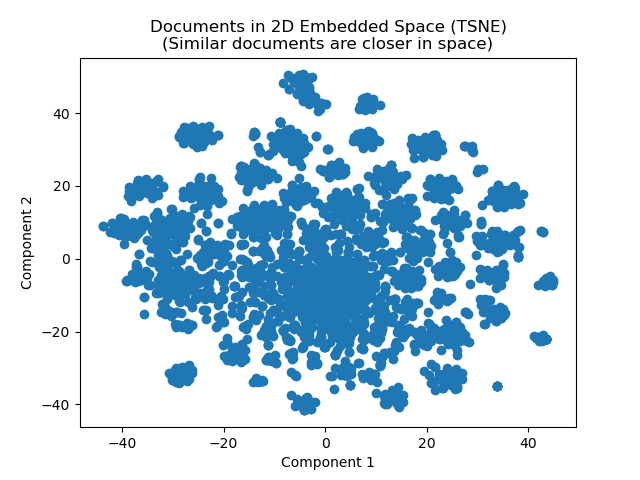

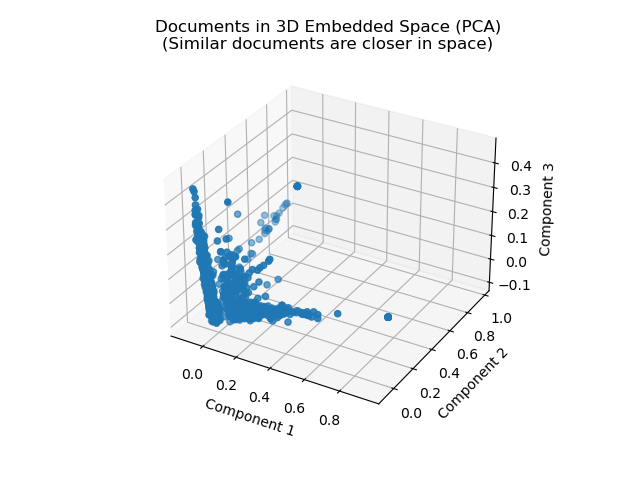

In [8]:
# perplexity is a hyperparameter specific to t-SNE, see documentation for more 
# info
plot_document_matrix(doc_term, decomposer='tsne', perplexity=50)
plot_document_matrix(doc_term, decomposer='pca', dimension=3, n_samples=5000)

## 3. Topic Modelling

`sklearn` documentation for [LDA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html), user guide [here](https://scikit-learn.org/stable/modules/decomposition.html#latentdirichletallocation).


**WARNING** - Process time increase as `max_iter` and the size of the corpus increase. Usually we should have at least 100 iterations for LDA but since this is just an example, we will use the default 10 iterations. It's usually a good idea to save your model using `pickle` (see [model_training.ipynb](./model_training.ipynb)).

The model after `fit_transform()` stores the topic-terms matrix in its `components_` attribute, where `components_[i, j]` stores the `j`-th word for topic `i`. The document-topics matrix is the output of `transform()` (or `fit_transform()`, in this case).

In [9]:
# Set verbose=1 if you want to see progress of the training
model = LatentDirichletAllocation(n_components=n_topics, max_iter=10, verbose=0)
doc_topics = model.fit_transform(doc_term)

Other models are also available, such as:
- [Non-negative Matrix Factorisation (NMF)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html#sklearn.decomposition.NMF) (user guide [here](https://scikit-learn.org/stable/modules/decomposition.html#nmf))
- [Latent Semantic Analysis (LSA)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) (user guide [here](https://scikit-learn.org/stable/modules/decomposition.html#lsa))

The syntax is still the same, so replacing `LatentDirichletAllocation()` in the above cell with the respective class should still work.

## 4. Results

In [12]:
# if dump_to_file=True, result is dumped to a text file. You can specify the
# name of the text file in the parameters.

print_topic_terms(
    topic_terms=model.components_, 
    vocab=vect.get_feature_names_out(), 
    n_words=5,
    dump_to_file=False
)

# Result is dumped to doc_topics_dump.txt
print_doc_topics(
    doc_topics=doc_topics,
    corpus=df['tweet'],   # Unprocessed corpus
    dump_to_file=True
)

Top 5 words for topic #0:
['buy', 'good', 'due', 'diligence', 'due diligence']


Top 5 words for topic #1:
['account', 'like', 'tweet', 'bot', 'please']


Top 5 words for topic #2:
['buy', 'one', 'speech', 'try', 'free']


Top 5 words for topic #3:
['bot', 'court', 'le', 'time', 'buy']


Top 5 words for topic #4:
['like', 'buy', 'bot', 'back', 'ad']


Top 5 words for topic #5:
['bot', 'account', 'happy', 'birthday', 'happy birthday']




/home/tin/mambaforge/envs/gcrl2000/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


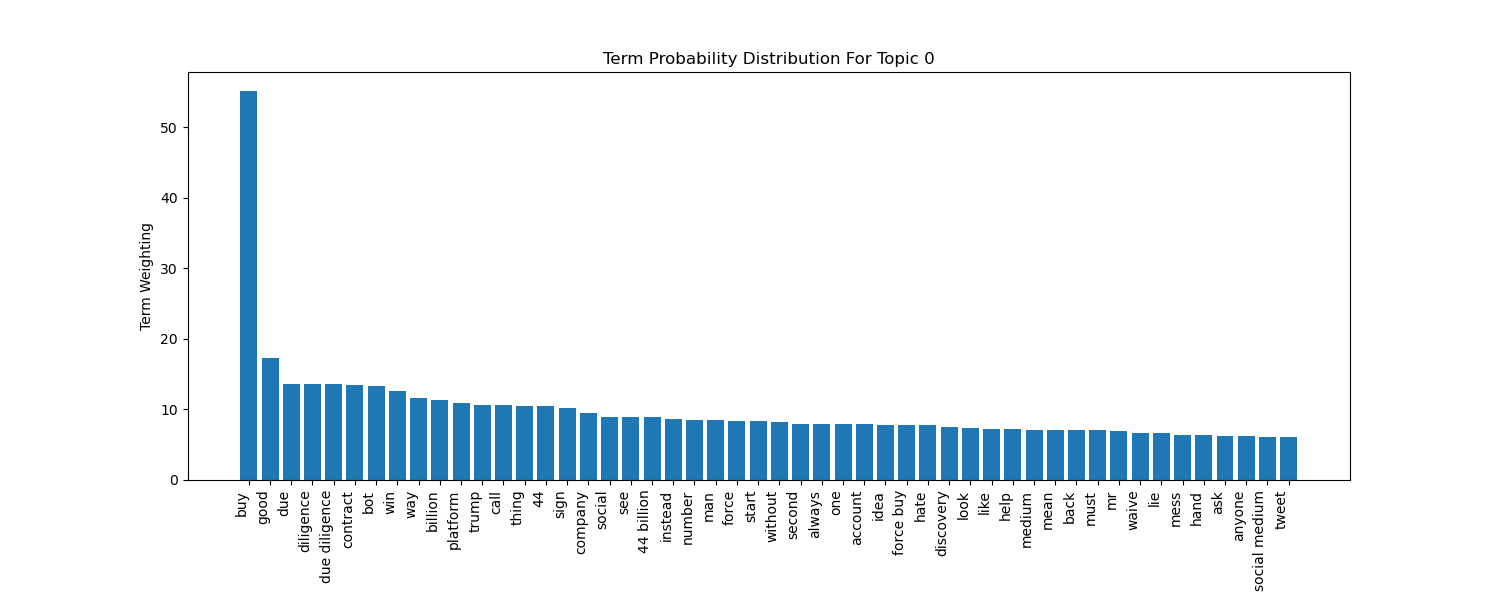

In [13]:
# Visualising the word distribution using bar-graph
graph_topic_terms_matrix(model.components_, vect.get_feature_names_out(), 0,
                         max_words=50)
plt.show()

/home/tin/mambaforge/envs/gcrl2000/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)
/home/tin/mambaforge/envs/gcrl2000/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


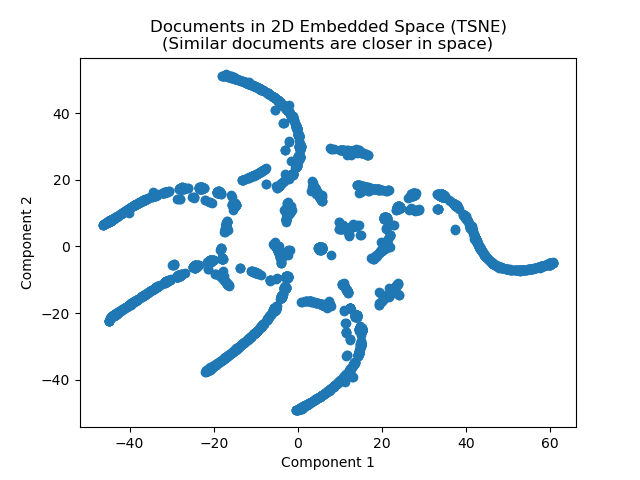

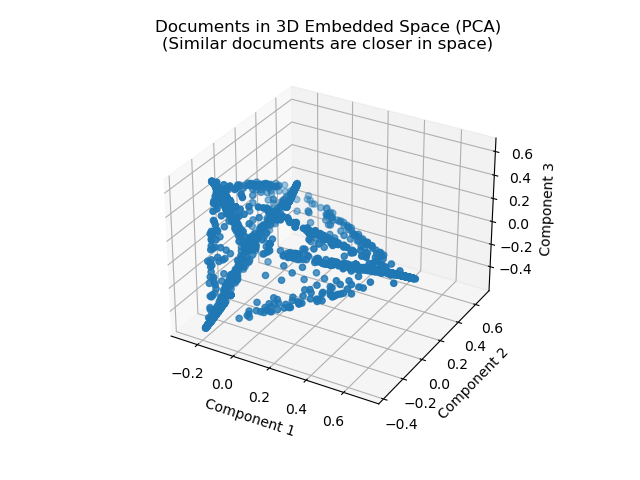

In [14]:
# Plotting the document-topic matrix
plot_document_matrix(doc_topics, decomposer='pca', dimension=3)
plot_document_matrix(doc_topics, decomposer='tsne', perplexity=50)
plt.show()

[`pyLDAvis`](https://pyldavis.readthedocs.io/en/latest/readme.html) is a dedicated LDA visualiser that provides more interactivity with the result. You should try adjusting the $\lambda$ slider on the right side of the panel to change how terms is sorted to get more interpretable topics.
- **WARNING** - in pyLDAvis, topic numbering starts at 1, and `components_[i]` doesn't equal to topic $i$ in pyLDAvis!! (i.e. the topic numbering changes)

In [15]:
# Another way of visualising topics using pyLDAvis
pyLDAvis.enable_notebook()

# pyLDAvis calls the wrong function name so we are creating an alias here
vect.get_feature_names = vect.get_feature_names_out
pyLDAvis.sklearn.prepare(model, doc_term, vect)

/home/tin/mambaforge/envs/gcrl2000/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.055133  0.051375       1        1  21.310638
1     -0.022334  0.046295       2        1  17.395224
5     -0.106356  0.029946       3        1  17.075393
3     -0.051369 -0.095232       4        1  15.783282
0      0.077319 -0.066093       5        1  14.637240
4      0.047607  0.033709       6        1  13.798222, topic_info=                Term        Freq       Total Category  logprob  loglift
1744           happy   26.000000   26.000000  Default  30.0000  30.0000
509         birthday   21.000000   21.000000  Default  29.0000  29.0000
1746  happy birthday   19.000000   19.000000  Default  28.0000  28.0000
673              buy  119.000000  119.000000  Default  27.0000  27.0000
3179          sample   27.000000   27.000000  Default  26.0000  26.0000
...              ...         ...         ...      ...      ...      ...
3293           share    5.813064   21.943128   Topic6  -5.9374   0.6523
1556        follower    6.348607   32.786317   Topic6  -5.8492   0.3389
2564             one    6.604010   53.400788   Topic6  -5.8098  -0.1095
2980            real    5.600096   24.682595   Topic6  -5.9747   0.4973
3238             see    5.871374   48.493729   Topic6  -5.9274  -0.1307

[436 rows x 6 columns], token_table=      Topic      Freq Term
term                      
1         1  0.158108   10
1         3  0.474324   10
1         4  0.158108   10
1         5  0.158108   10
3         1  0.127906  100
...     ...       ...  ...
4025      1  0.209658  yet
4025      2  0.489202  yet
4025      3  0.139772  yet
4025      5  0.069886  yet
4025      6  0.069886  yet

[1019 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 6, 4, 1, 5])